# Muestreo de pares de abstracts
Vamos a construir un csv que tenga pares de abstracts, sus fenotipos asociados y su similitud lin.

In [1]:
# Import global variables from project_config.py

import os
import sys
from IPython.core.getipython import get_ipython

# Absolute path of the current notebook
notebook_path = os.path.realpath(os.path.join(os.getcwd(), get_ipython().starting_dir))
# Add module to system path
src_path = os.path.dirname(notebook_path)
sys.path.append(src_path)

import project_config.project_config
from project_config.project_config import *
from util.clean_abstracts import clean_abstract
from util.samples import random_combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from cmath import nan
from util.clean_abstracts import countPapers, getIndex
from sklearn.utils import resample

[nltk_data] Downloading package punkt to /home/domingo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/domingo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 1. Load abstracts and index data

NAME_ABSTRACTS = 'abstracts-31-05-train'

NAME_INDEX = "index-31-05-train"
NAME_PHEN = "phenotypes_nz_05-05_10"

PATH_ABSTRACTS_CSV = PATH_ABSTRACTS + '/' + NAME_ABSTRACTS + ".csv"
PATH_INDEX_CSV = PATH_PHENOTYPES +'/'+ NAME_INDEX + ".csv"
PATH_DATA_FENOTIPOS = PATH_PHENOTYPES + '/' + NAME_PHEN + ".csv"

dfPhen = pd.read_csv(PATH_DATA_FENOTIPOS, sep='\t', low_memory=False, na_values=['', nan])
dfIndex = pd.read_csv(PATH_INDEX_CSV, sep='\t', low_memory=False, na_values=['', nan])

In [3]:
dfAbstracts = pd.read_csv(PATH_ABSTRACTS_CSV, sep='\t', low_memory=False, na_values=['', nan])

In [4]:
dfPapers = dfAbstracts
dfPapers.info()
dfIndex.info()
dfPhen.info()

m = dfIndex.shape[0]
n = dfPapers.shape[0]
print(f"Number of papers: {n}, Number of phen: {m}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802664 entries, 0 to 802663
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   paperId         802664 non-null  int64 
 1   phenotypeId     802664 non-null  object
 2   phenotypeName   802664 non-null  object
 3   title           802664 non-null  object
 4   clean_abstract  802664 non-null  object
 5   length          802664 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 36.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    4070 non-null   object
 1   numberPapers   4070 non-null   int64 
 2   phenotypeName  4070 non-null   object
dtypes: int64(1), object(2)
memory usage: 95.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 8 columns):
 

In [5]:
from datetime import datetime

s = datetime.today().strftime('%d-%m')

import math
import random
from itertools import combinations
import bisect

from pyhpo import Ontology

dfIndex['numberPapers'].describe()

count    4070.000000
mean      197.214742
std        67.197194
min        39.000000
25%       156.000000
50%       239.000000
75%       239.000000
max       239.000000
Name: numberPapers, dtype: float64

## Muestreo 1

Para cada fenotipo muestrear 10 abstracts, después muestrear todos los 2os abstracts, calcular similitud lin entre tags. Así se consigue que cada etiqueta (fenotipo) tenga al menos 10 ejemplos.

In [6]:
dict = {'paperId1' : [], 'phenId1' : [], 'phenName1' : [], 'title1' : [], 'text1' : [], 'len1' : [],
        'paperId2' : [], 'phenId2' : [], 'phenName2' : [], 'title2' : [], 'text2' : [], 'len2' : []}

for phenotypeName in dfIndex['phenotypeName']:
    # muestra de 10 papers
    papers = dfPapers[dfPapers['phenotypeName'] == phenotypeName].sample(10)
    dict['paperId1'] += papers['paperId'].tolist()
    dict['phenId1'] += papers['phenotypeId'].tolist()
    dict['phenName1'] += papers['phenotypeName'].tolist()
    dict['title1'] += papers['title'].tolist()
    dict['text1'] += papers['clean_abstract'].tolist()
    dict['len1'] += papers['length'].tolist()

# Muestreo de los papers restantes
papers = dfPapers.sample(m*10)
dict['paperId2'] += papers['paperId'].tolist()
dict['phenId2'] += papers['phenotypeId'].tolist()
dict['phenName2'] += papers['phenotypeName'].tolist()
dict['title2'] += papers['title'].tolist()
dict['text2'] += papers['clean_abstract'].tolist()
dict['len2'] += papers['length'].tolist()

dfPairings = pd.DataFrame(dict)
dfPairings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40700 entries, 0 to 40699
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paperId1   40700 non-null  int64 
 1   phenId1    40700 non-null  object
 2   phenName1  40700 non-null  object
 3   title1     40700 non-null  object
 4   text1      40700 non-null  object
 5   len1       40700 non-null  int64 
 6   paperId2   40700 non-null  int64 
 7   phenId2    40700 non-null  object
 8   phenName2  40700 non-null  object
 9   title2     40700 non-null  object
 10  text2      40700 non-null  object
 11  len2       40700 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.7+ MB


In [7]:
dfPairings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40700 entries, 0 to 40699
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paperId1   40700 non-null  int64 
 1   phenId1    40700 non-null  object
 2   phenName1  40700 non-null  object
 3   title1     40700 non-null  object
 4   text1      40700 non-null  object
 5   len1       40700 non-null  int64 
 6   paperId2   40700 non-null  int64 
 7   phenId2    40700 non-null  object
 8   phenName2  40700 non-null  object
 9   title2     40700 non-null  object
 10  text2      40700 non-null  object
 11  len2       40700 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.7+ MB


In [8]:
# Agregar similitud Lin

from util.phenotypes import getSim

dfPairings['similarity'] = dfPairings.apply(lambda row: getSim(row['phenName1'], row['phenName2']), axis=1)


In [10]:
dfPairings['similarity'].describe()

# plot

s

count    40700.000000
mean         0.026406
std          0.089197
min          0.000000
25%          0.000044
50%          0.000050
75%          0.000080
max          1.832676
Name: similarity, dtype: float64

<Axes: xlabel='similarity', ylabel='Density'>

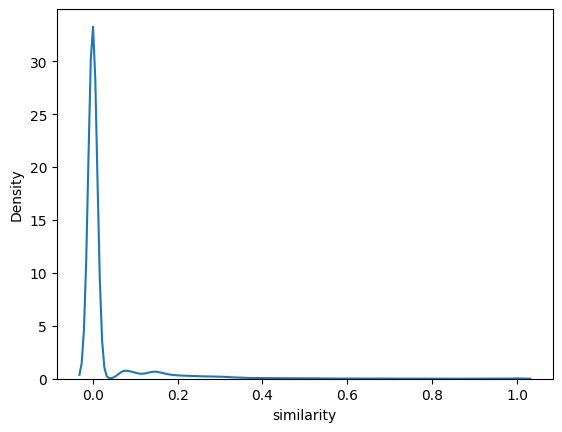

In [13]:
dfPairings['similarity'] = dfPairings['similarity'].apply(lambda x: min(x, 1))
import seaborn as sns

sns.kdeplot(dfPairings['similarity'])

In [14]:
s = datetime.today().strftime('%d-%m')
dfPairings.to_csv(PATH_ABSTRACTS + '/pairings-' + s + '.csv', sep='\t', index=False)

# Muestra 2: Mismo tamaño que el total de abstracts


In [17]:
dfPapers2 = dfPapers.sample(n, replace=True)

In [18]:
dic2 = {}
for colname in dfPapers.columns:
    dic2[colname + '1'] = dfPapers[colname].tolist()
    dic2[colname + '2'] = dfPapers2[colname].tolist()

dfPairings2 = pd.DataFrame(dic2)
dfPairings2['text1'] = dfPairings2['clean_abstract1']
dfPairings2['text2'] = dfPairings2['clean_abstract2']
dfPairings2['len1'] = dfPairings2['length1']
dfPairings2['len2'] = dfPairings2['length2']
dfPairings2.drop(columns=['clean_abstract1', 'clean_abstract2', 'length1', 'length2'], inplace=True)
dfPairings2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802664 entries, 0 to 802663
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   paperId1        802664 non-null  int64 
 1   paperId2        802664 non-null  int64 
 2   phenotypeId1    802664 non-null  object
 3   phenotypeId2    802664 non-null  object
 4   phenotypeName1  802664 non-null  object
 5   phenotypeName2  802664 non-null  object
 6   title1          802664 non-null  object
 7   title2          802664 non-null  object
 8   text1           802664 non-null  object
 9   text2           802664 non-null  object
 10  len1            802664 non-null  int64 
 11  len2            802664 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 73.5+ MB


In [19]:
dfPairings2['similarity'] = dfPairings2.apply(lambda row: getSim(row['phenotypeName1'], row['phenotypeName2']), axis=1)
dfPairings2['similarity'] = dfPairings2['similarity'].apply(lambda x: min(x, 1))

<Axes: xlabel='similarity', ylabel='Density'>

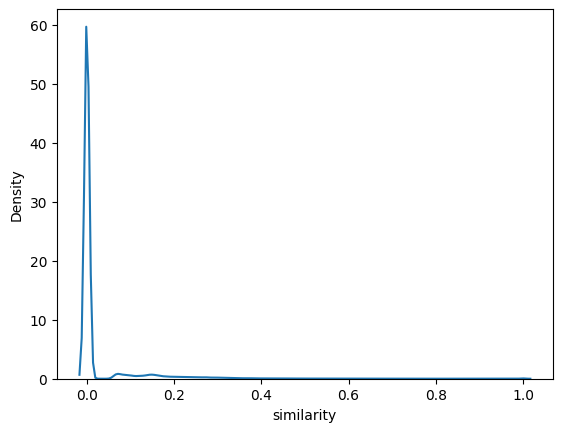

In [20]:
dfPairings2['similarity'].describe()
sns.kdeplot(dfPairings2['similarity'])

In [21]:
dfPairings2.to_csv(PATH_ABSTRACTS + '/pairings-' + s + '-full.csv', sep='\t', index=False)